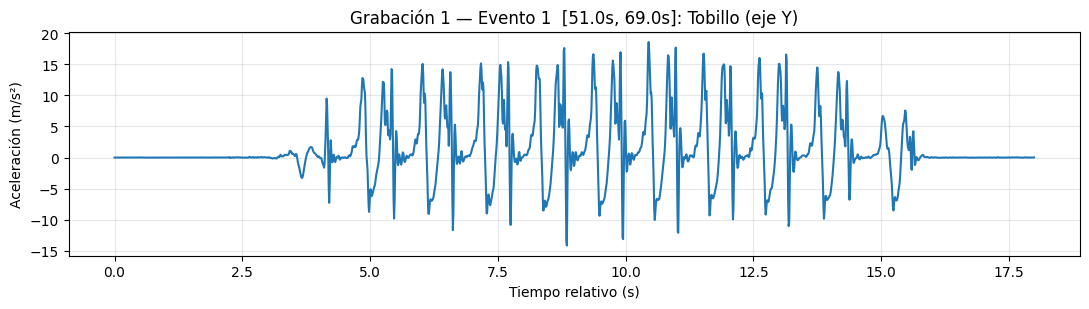

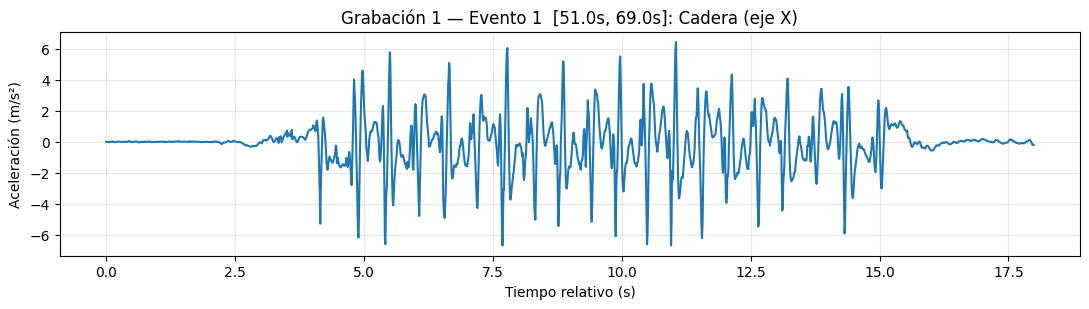

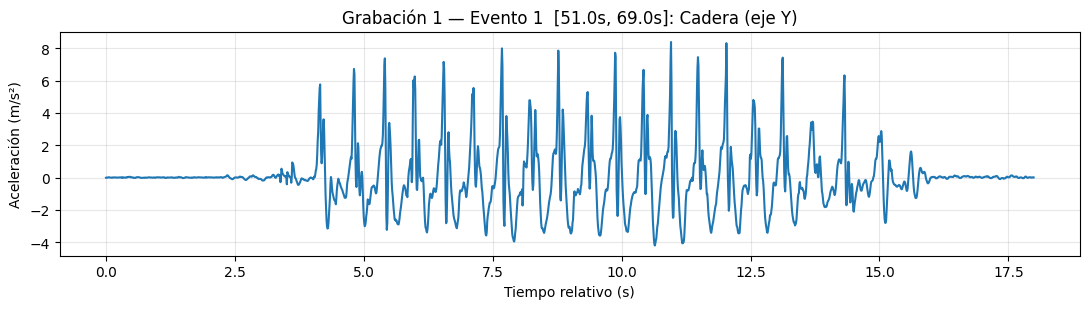

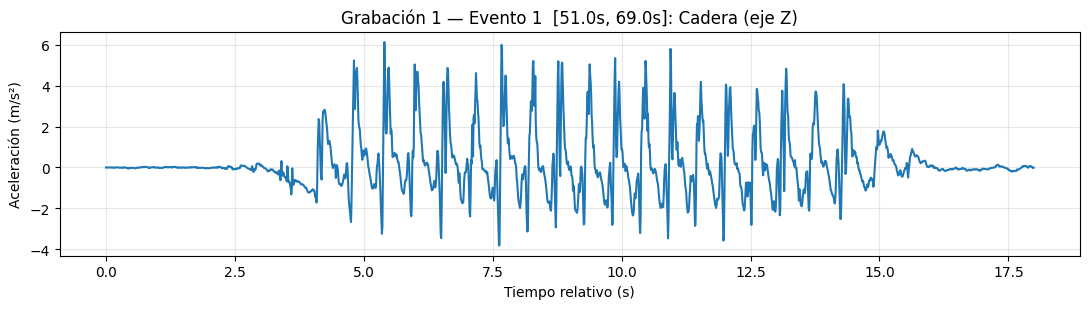

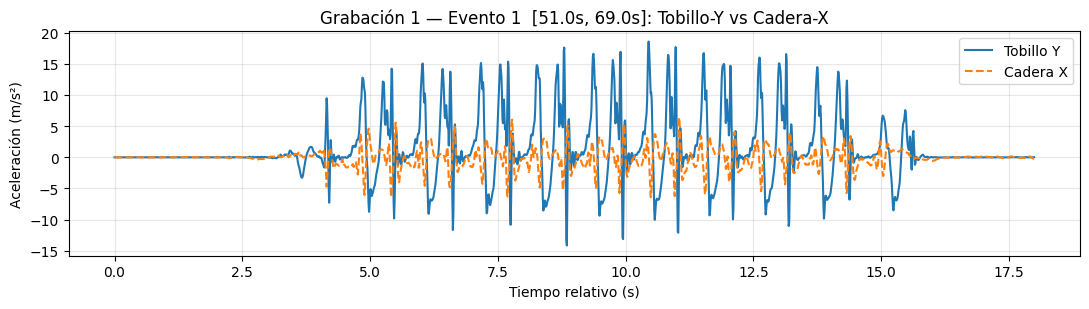

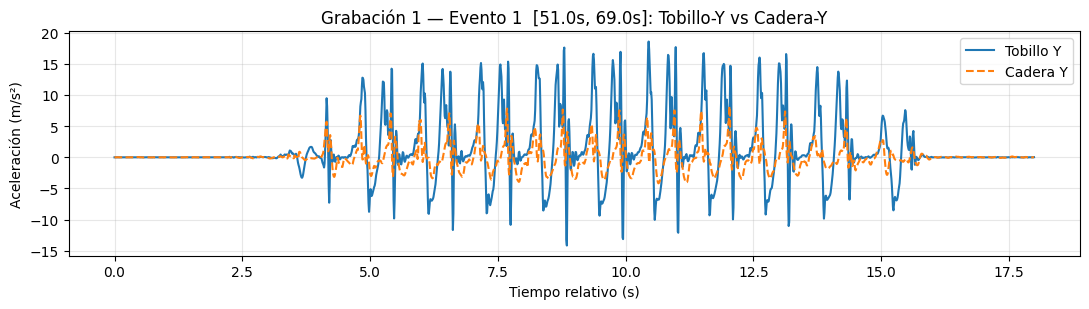

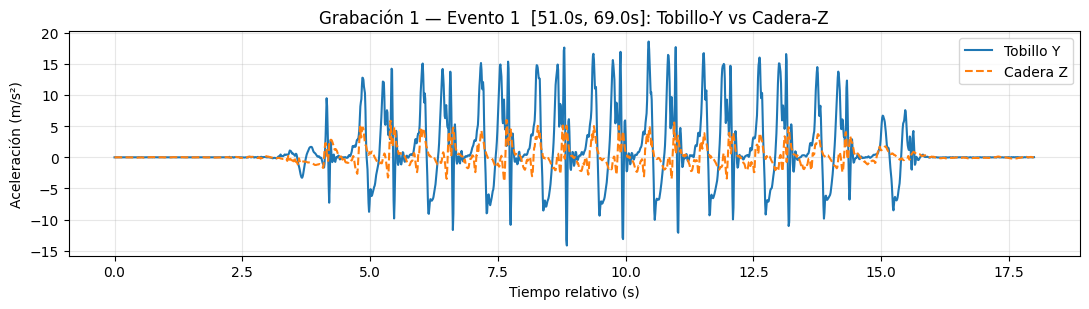

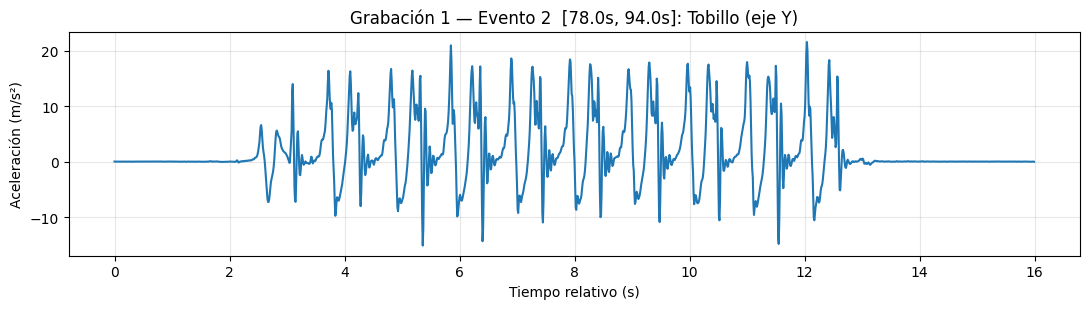

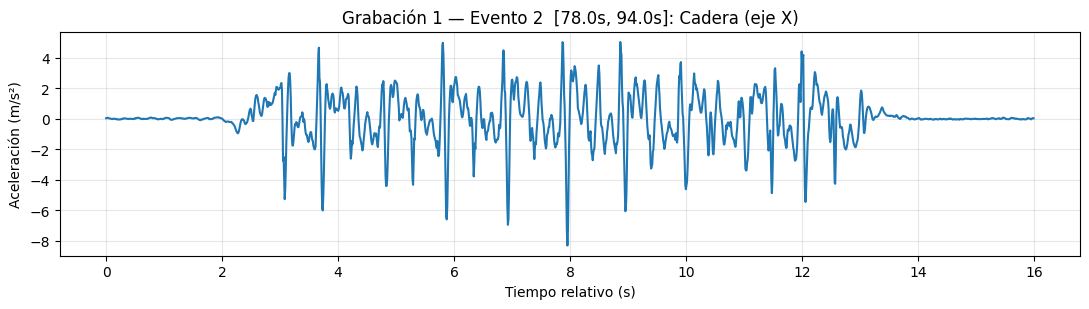

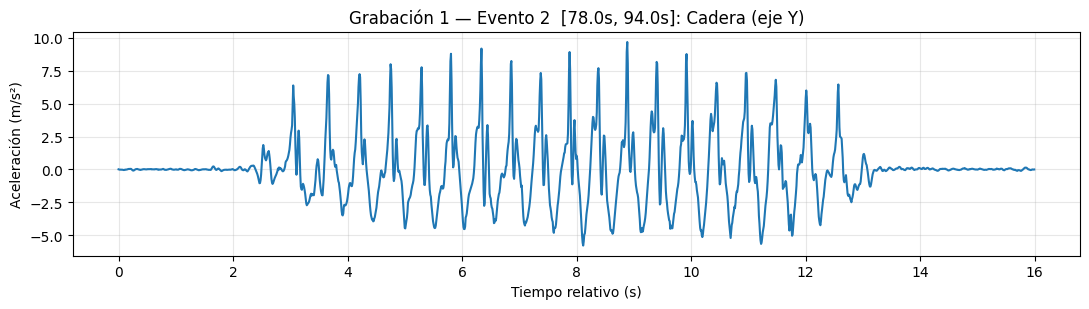

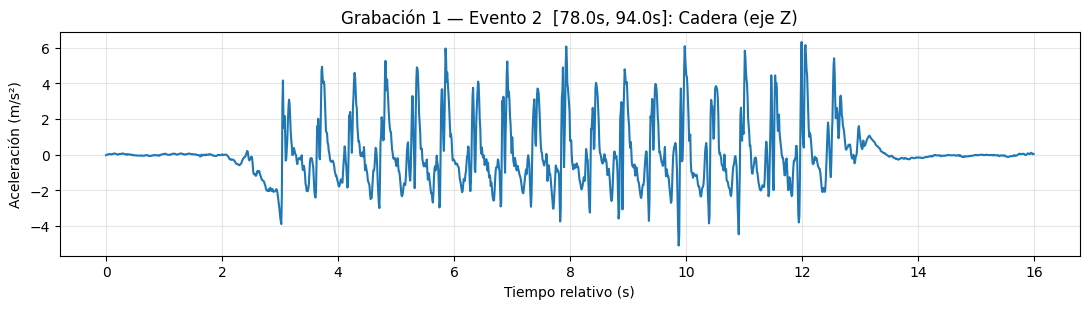

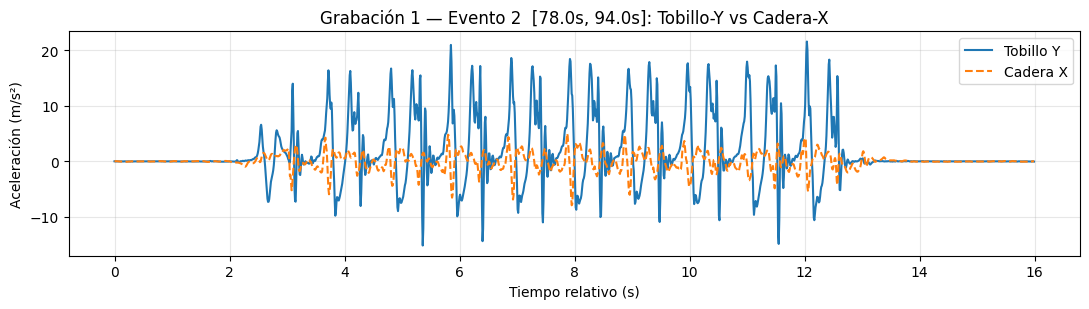

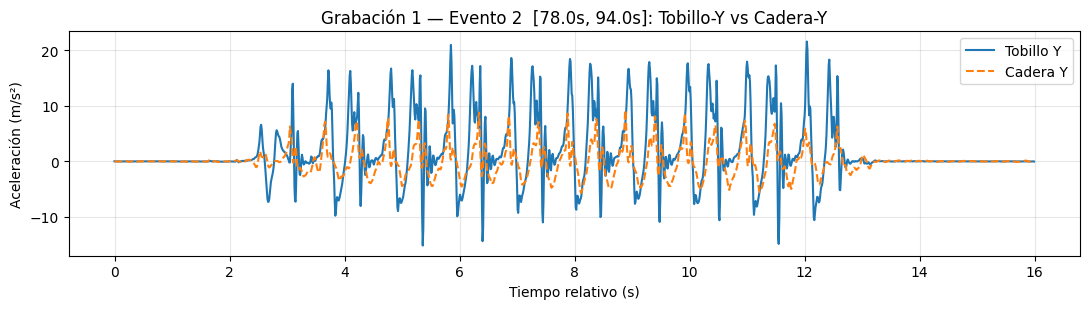

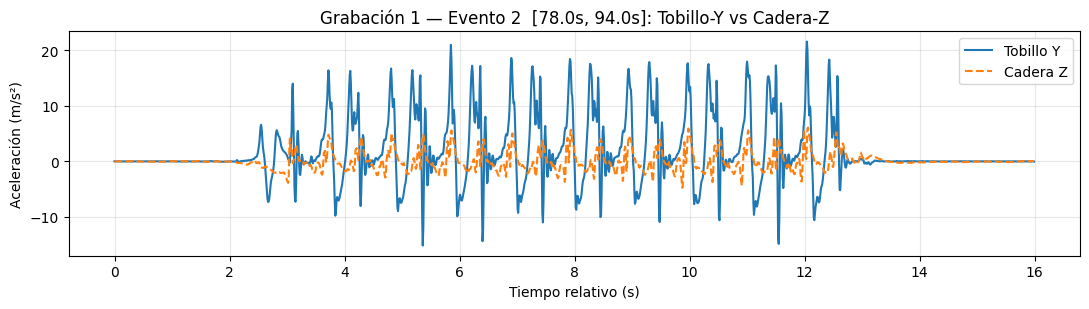

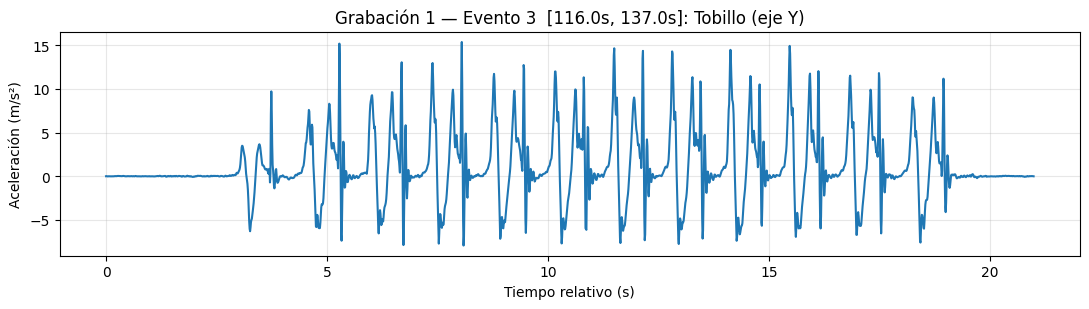

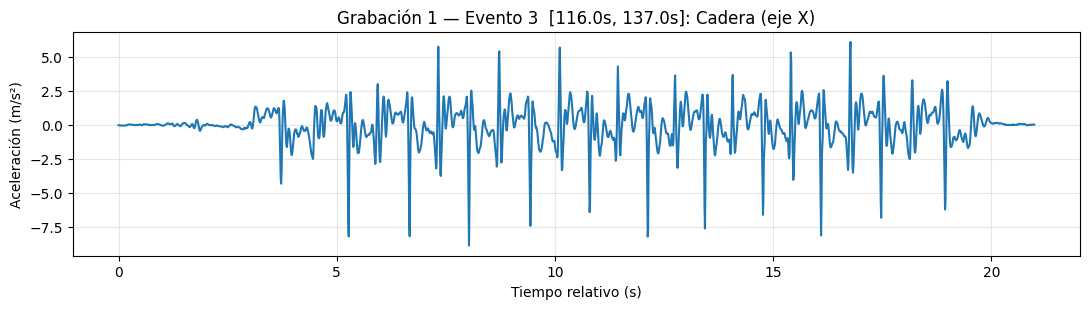

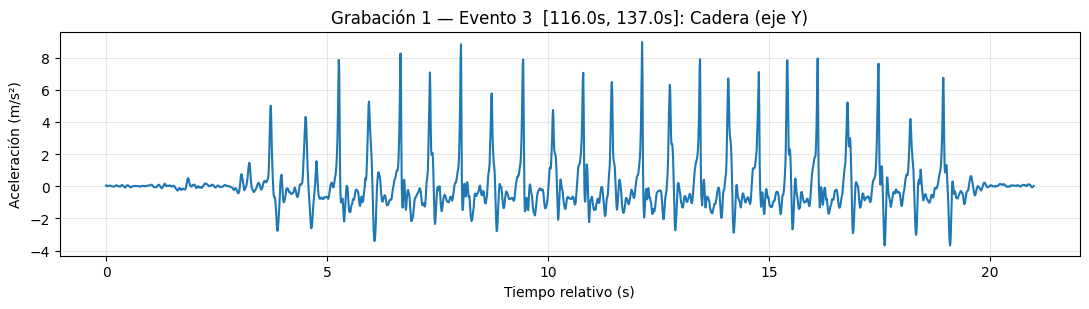

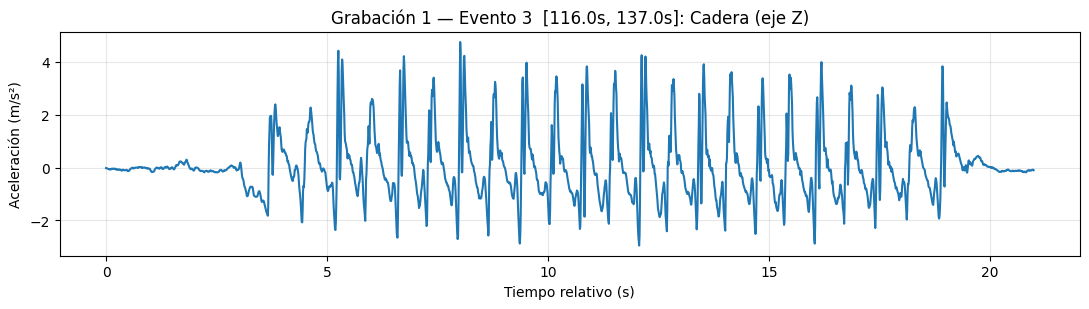

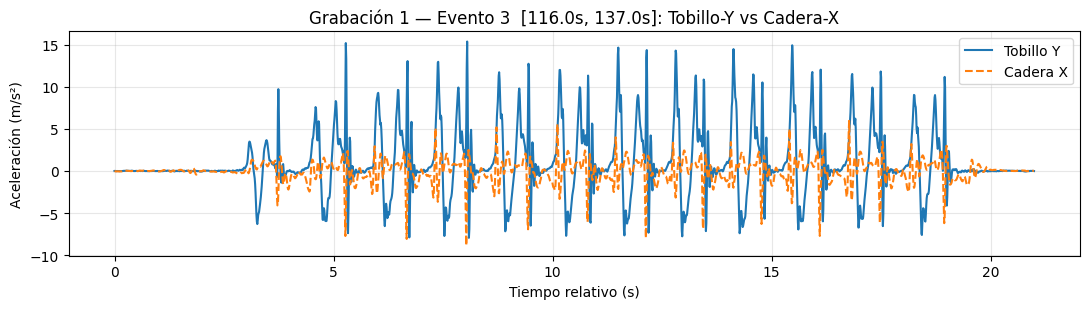

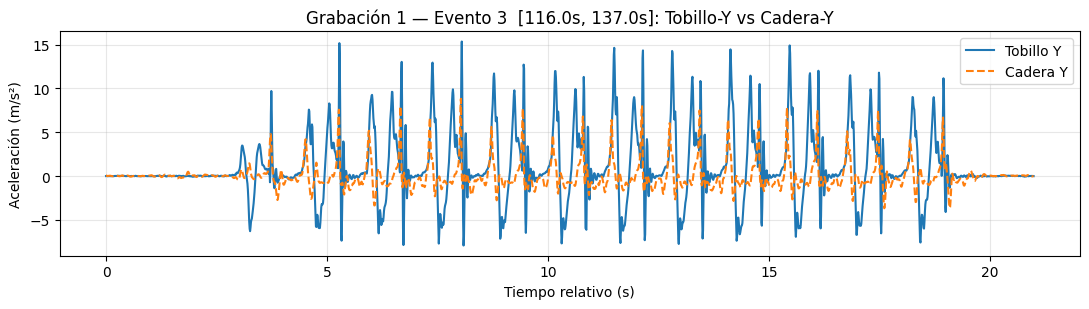

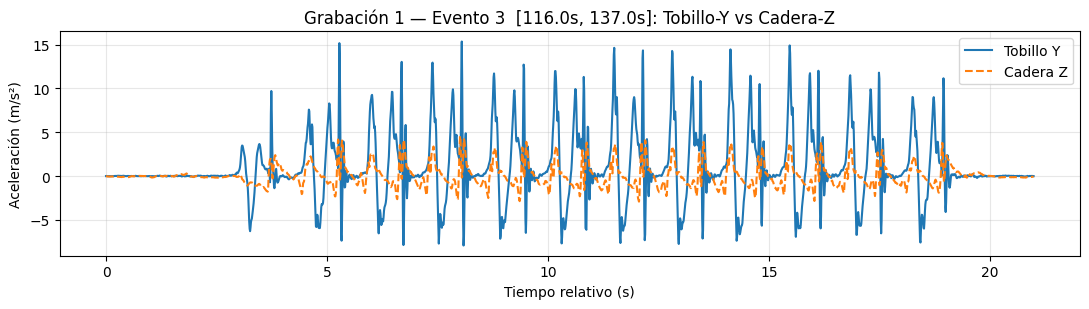

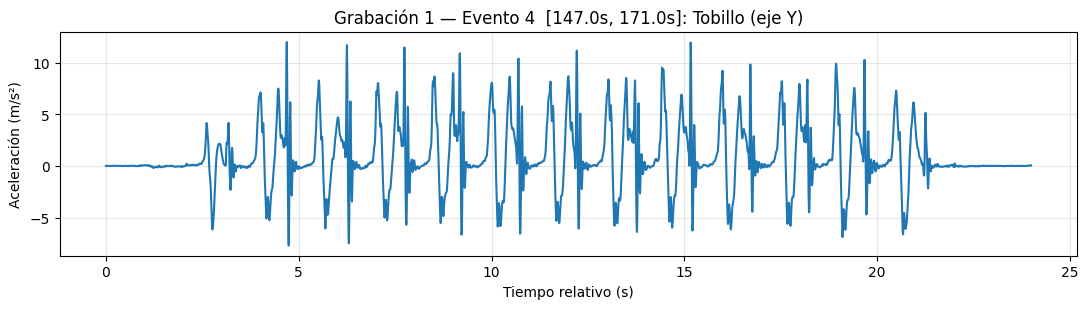

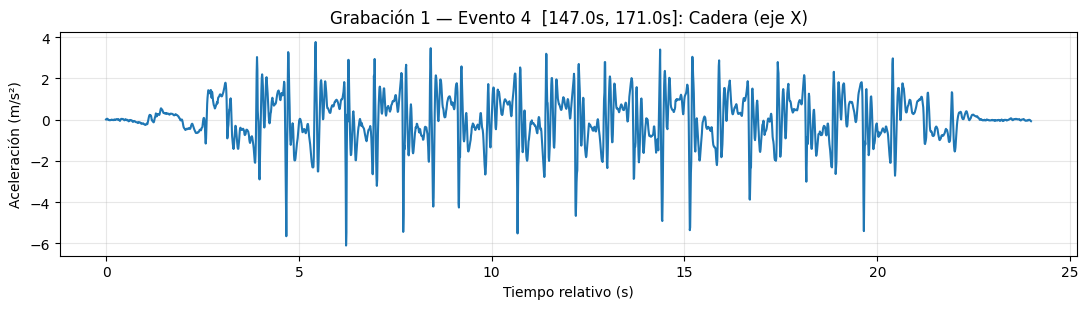

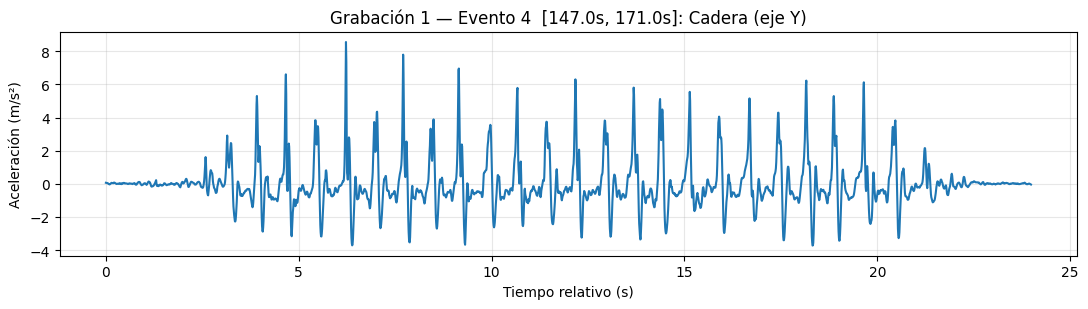

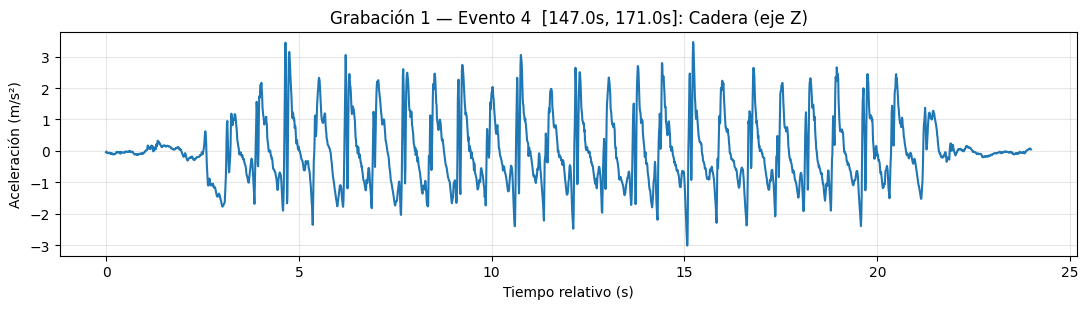

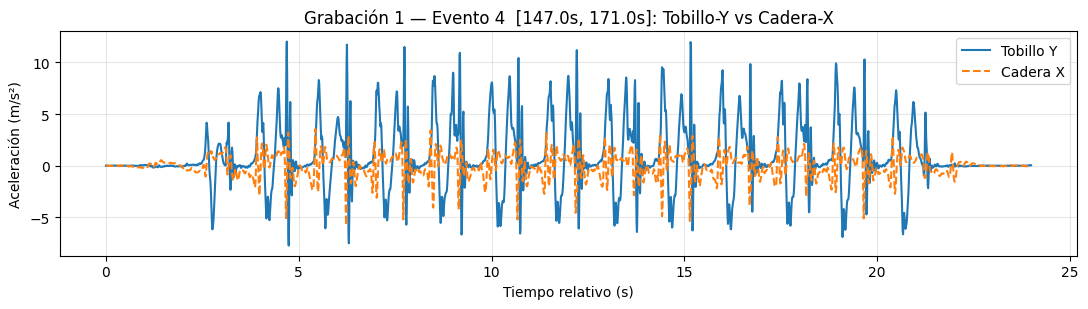

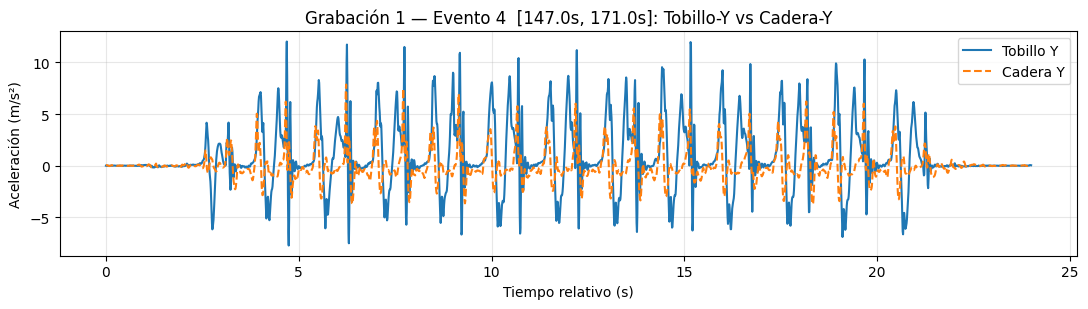

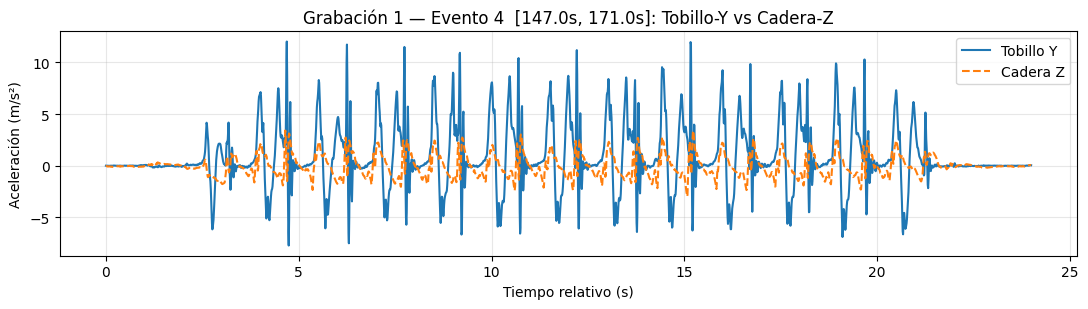

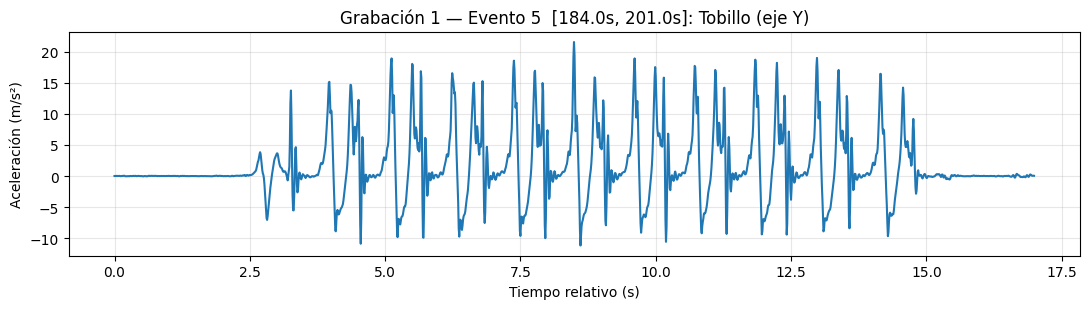

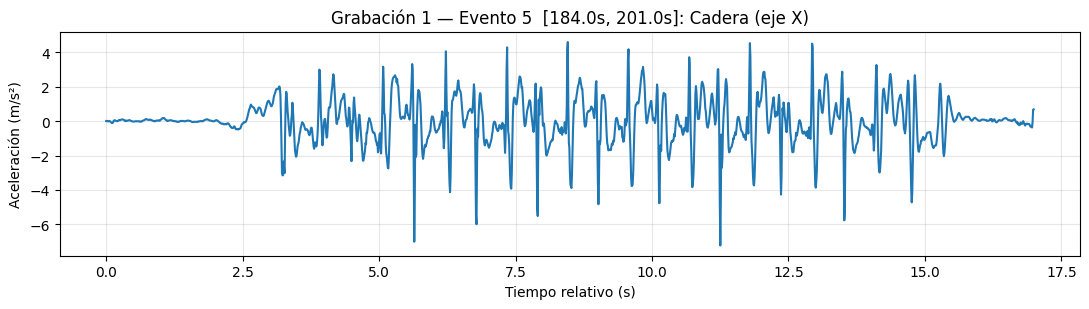

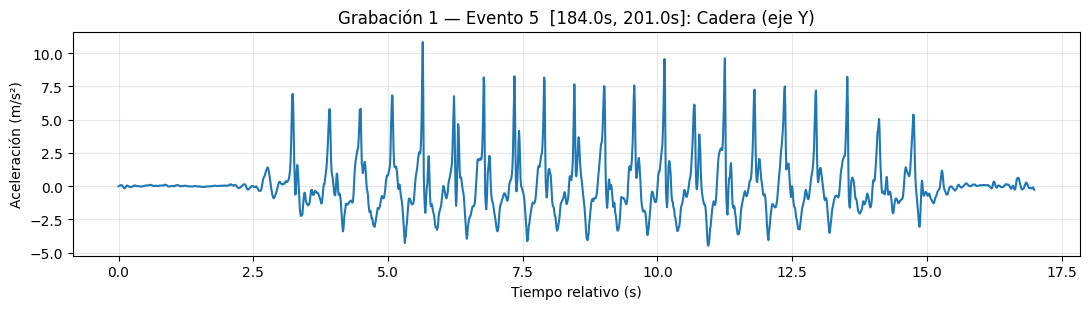

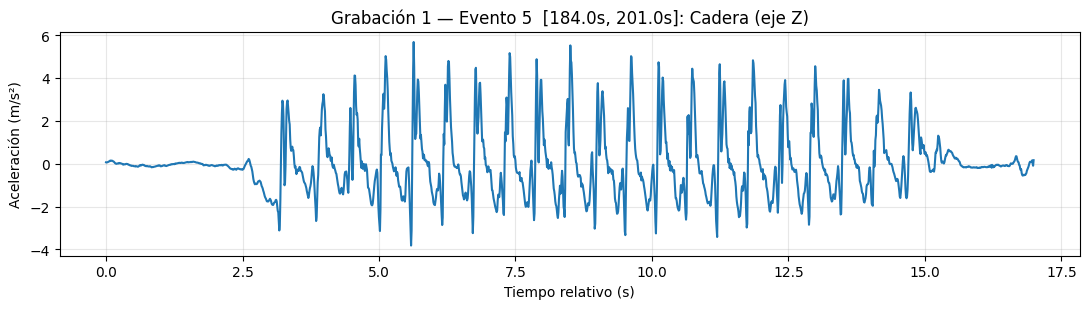

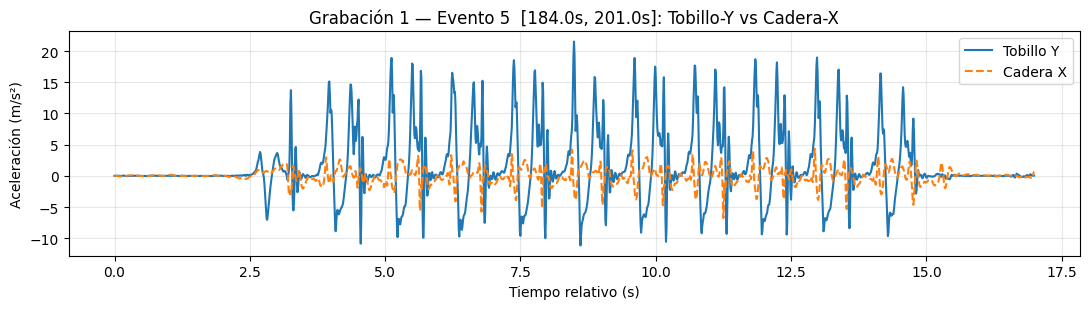

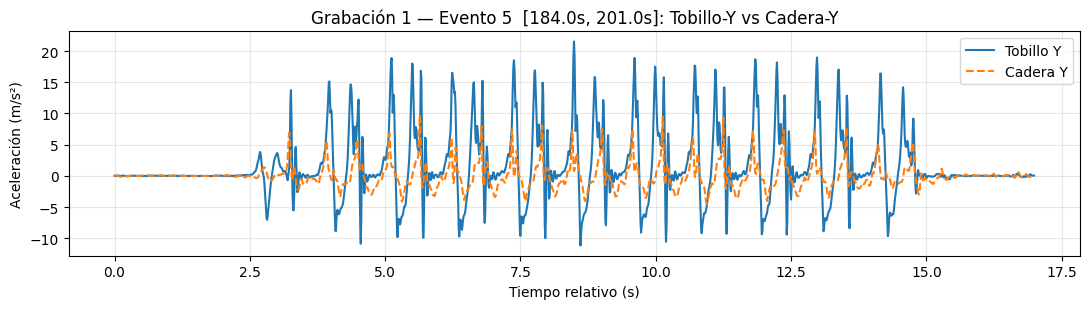

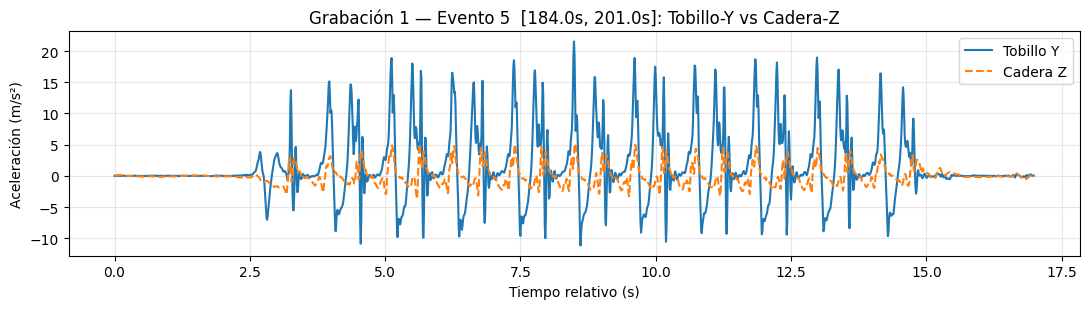

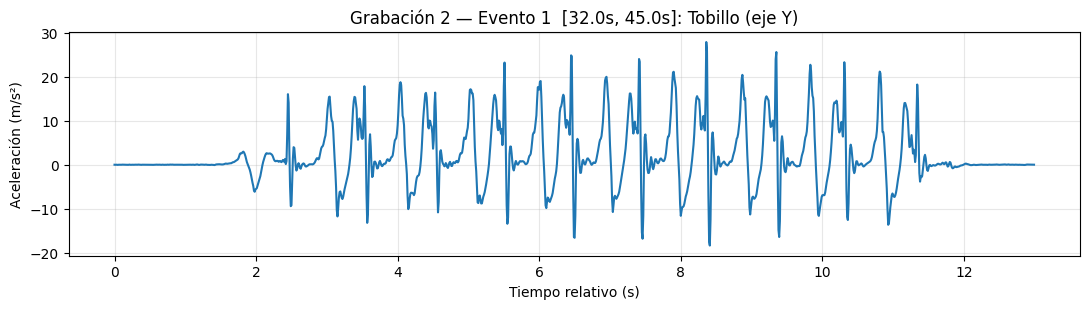

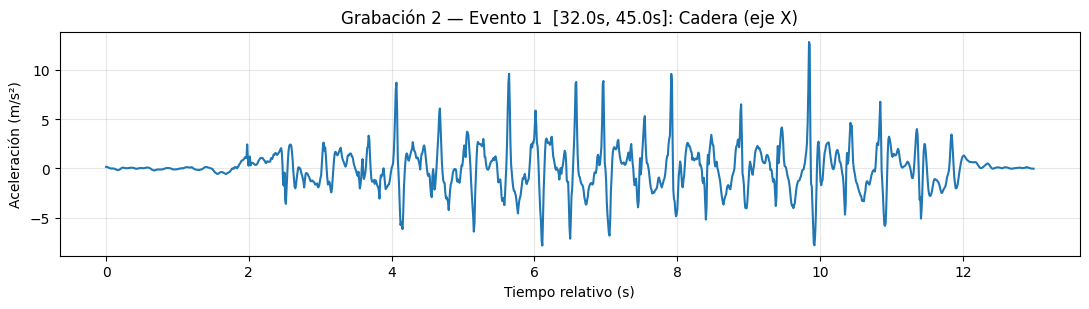

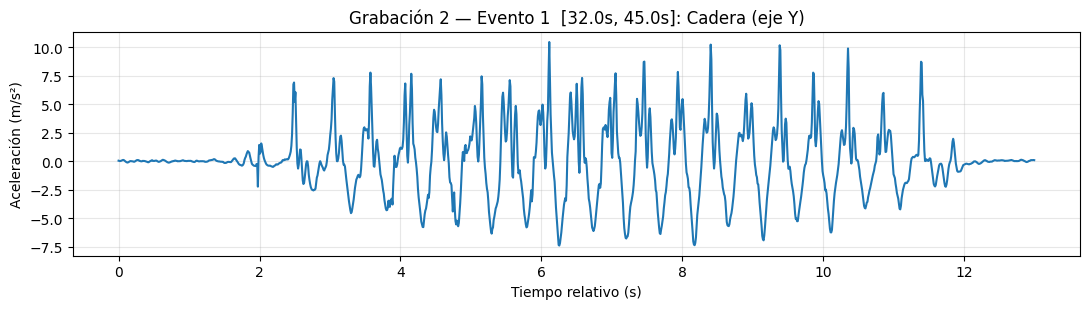

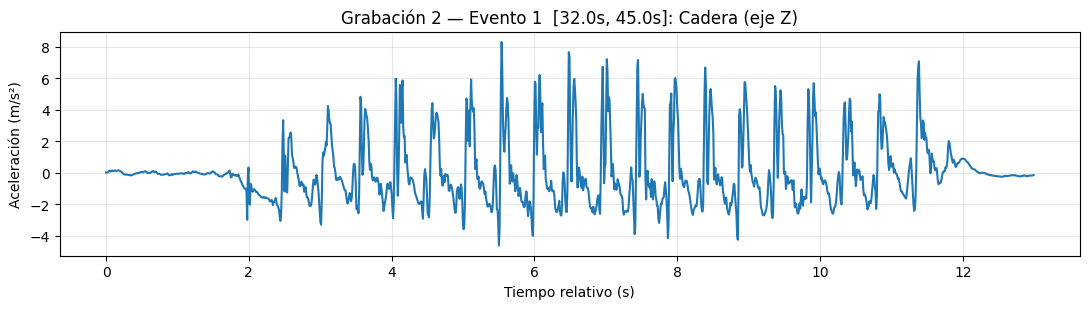

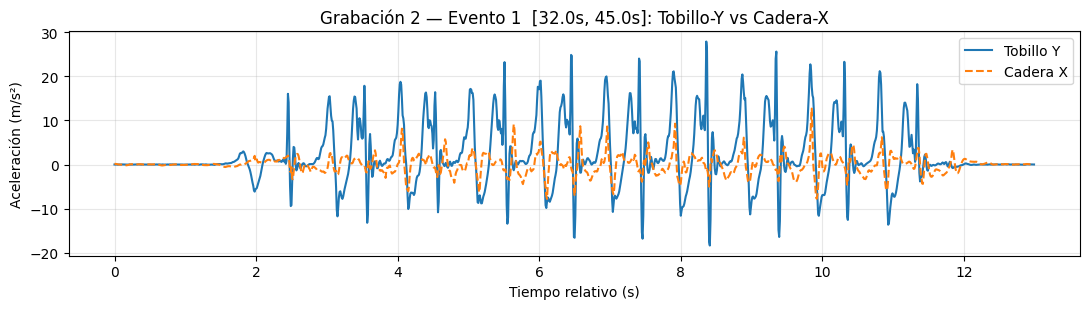

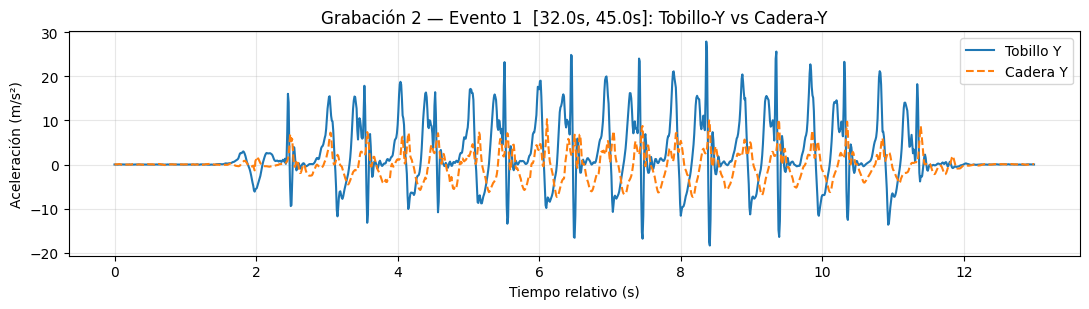

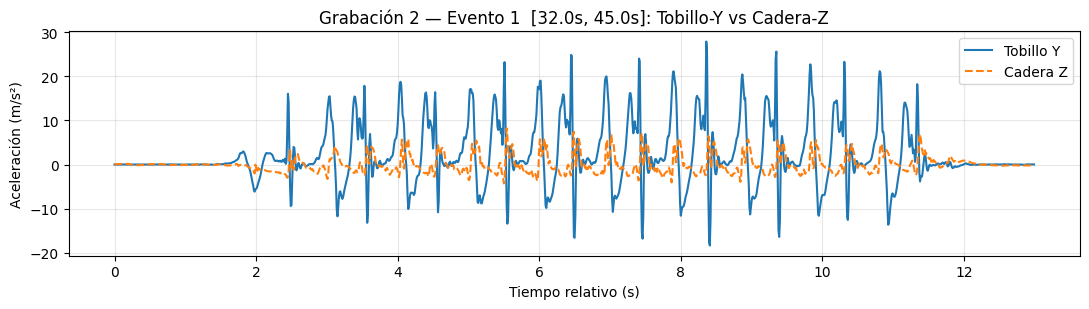

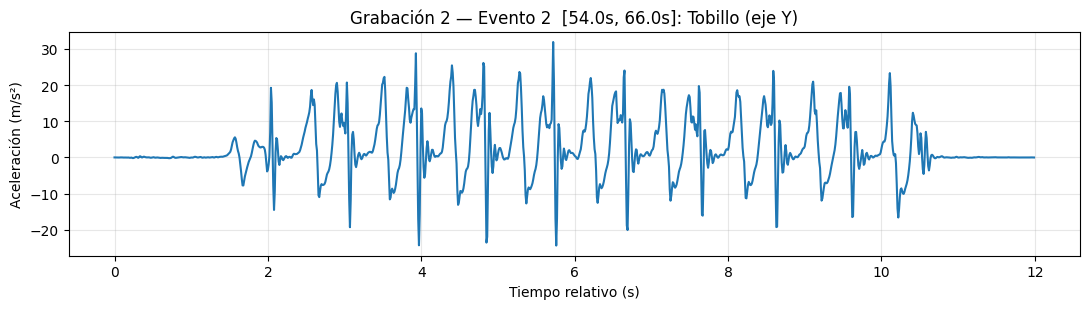

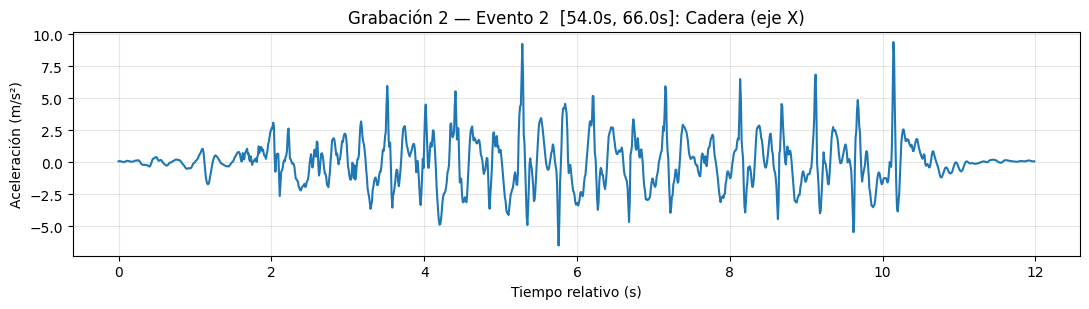

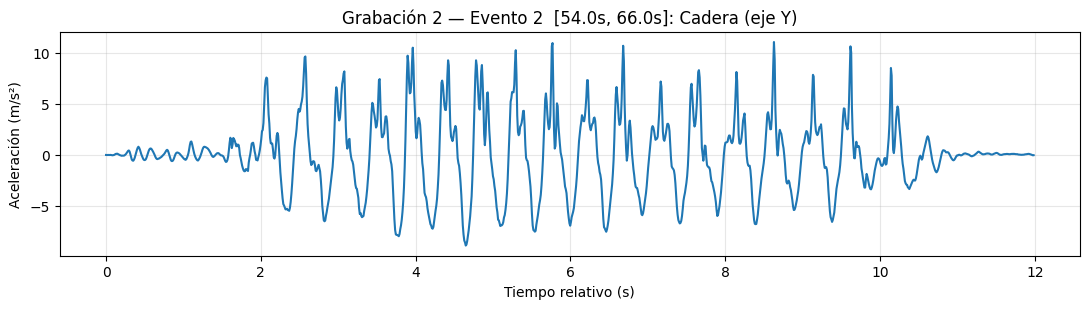

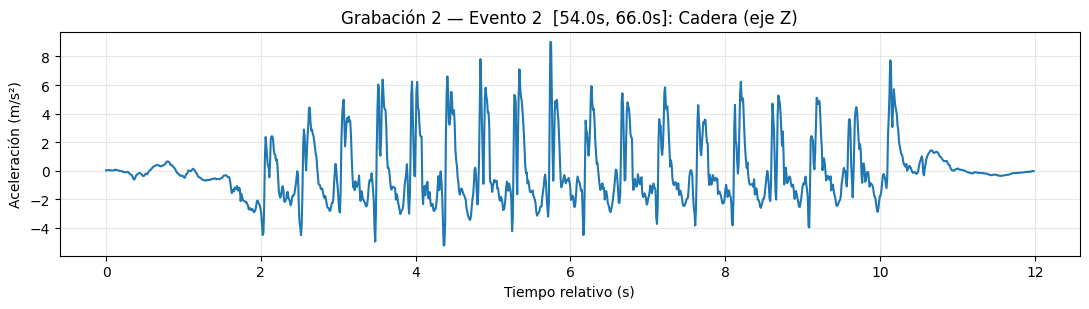

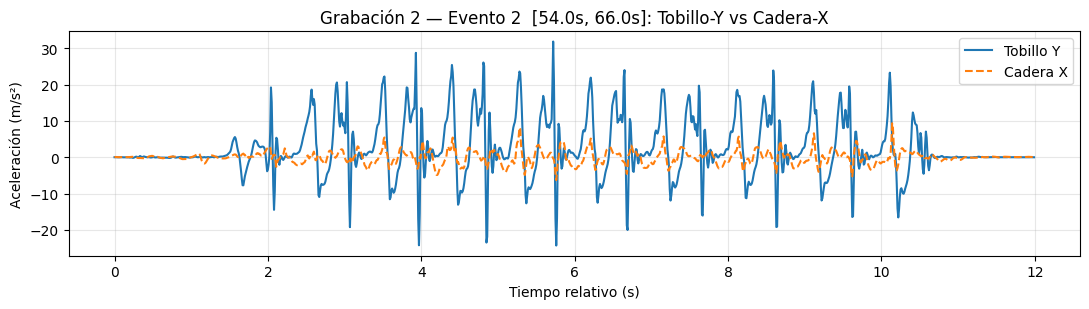

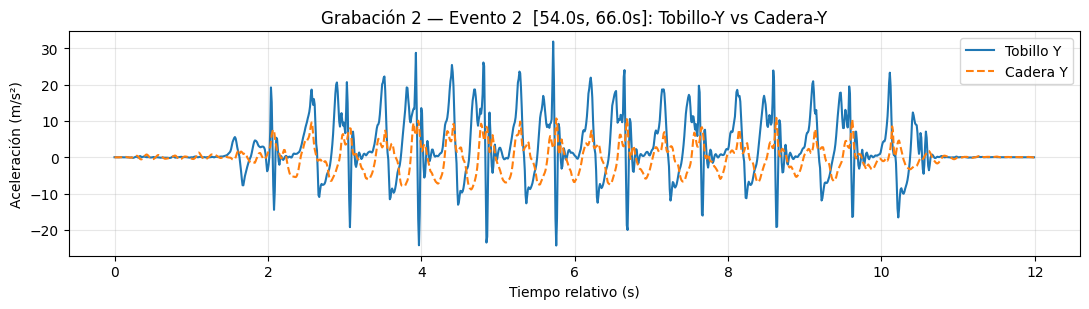

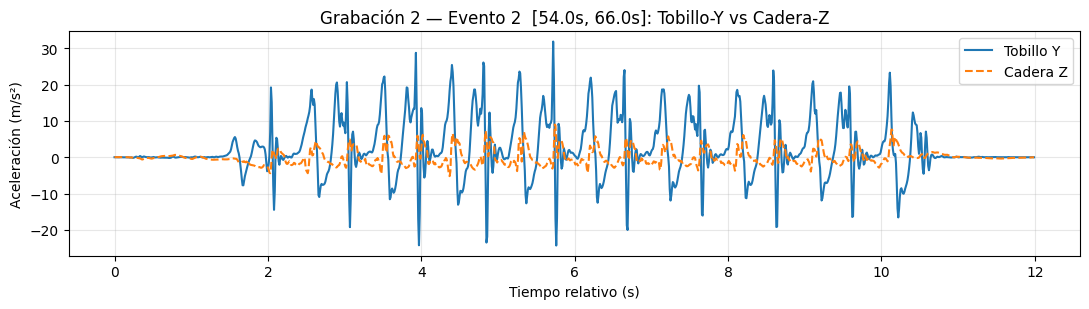

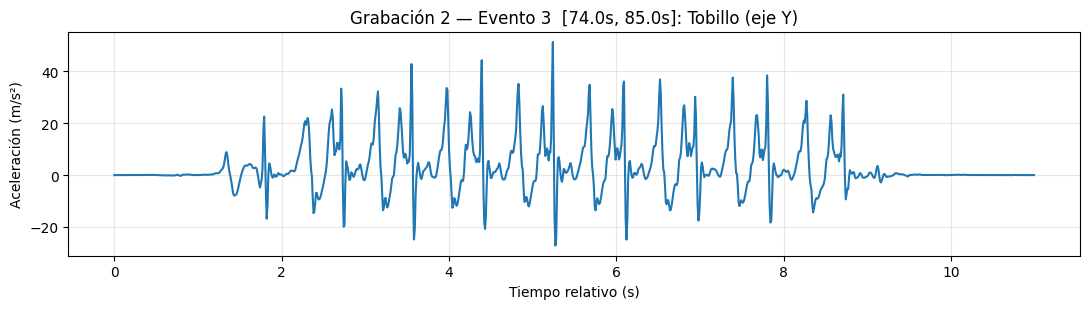

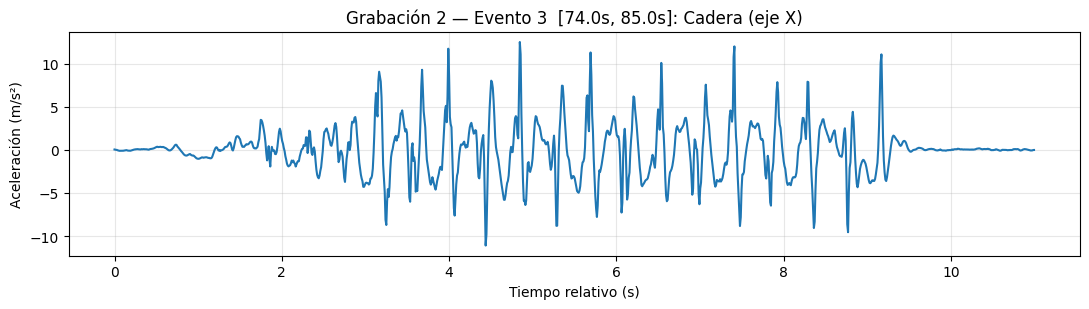

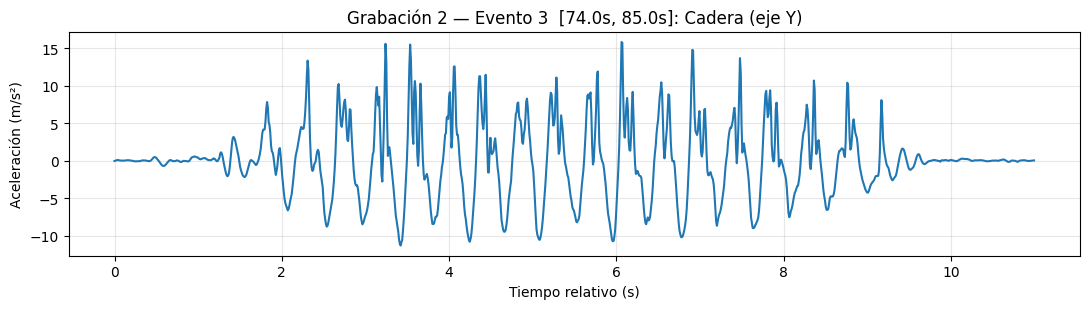

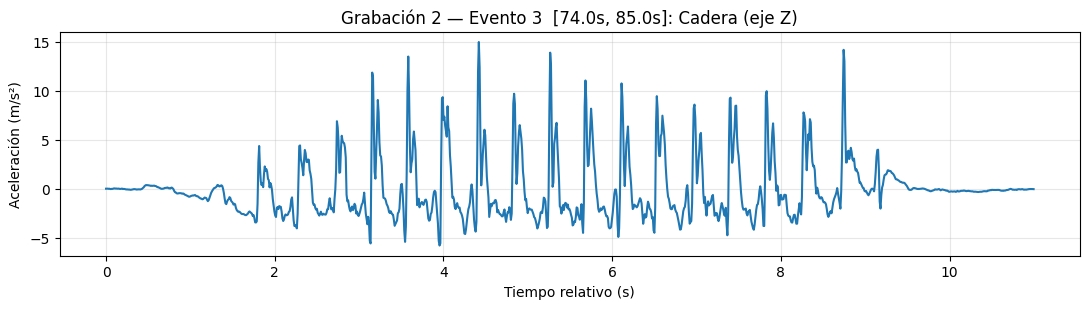

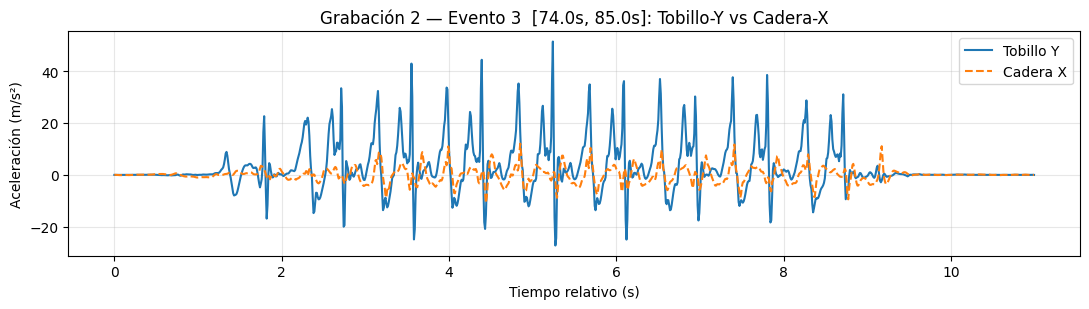

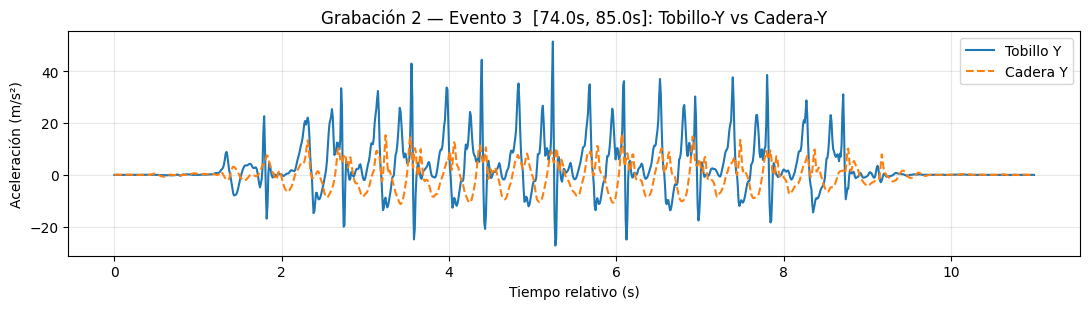

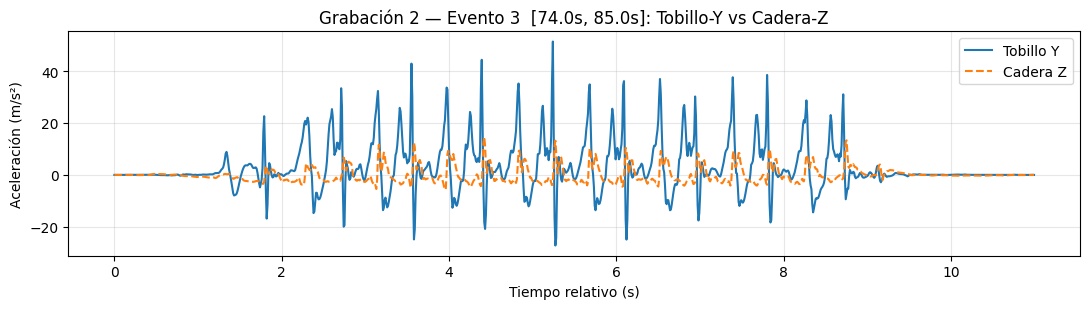

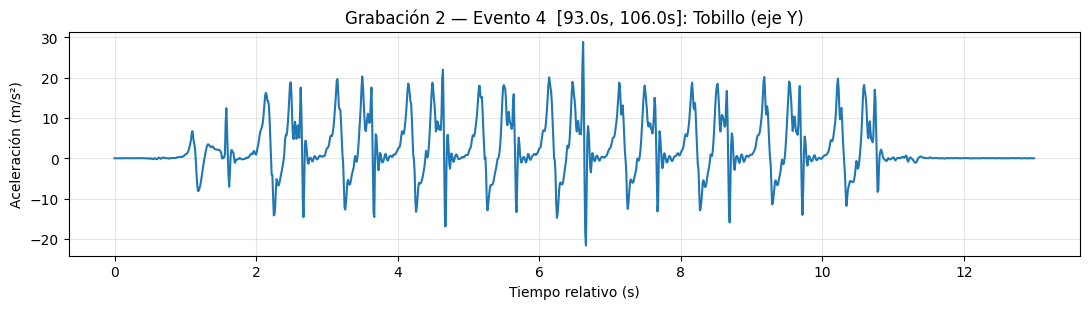

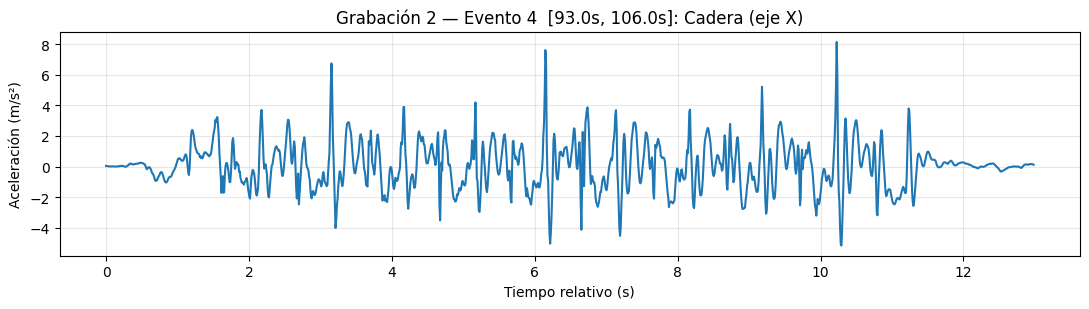

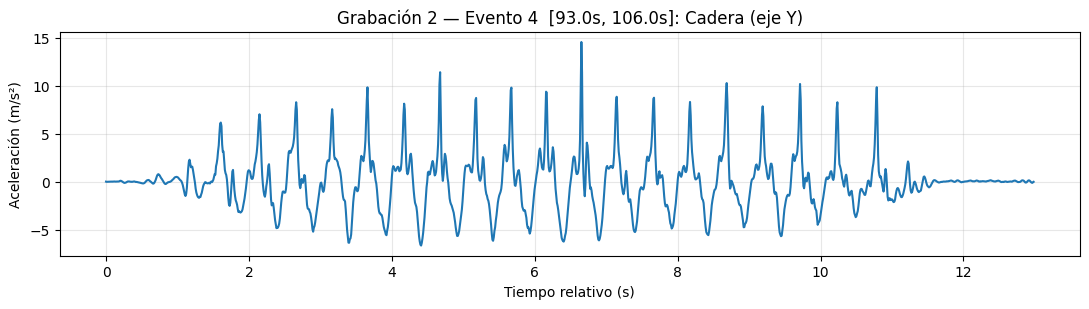

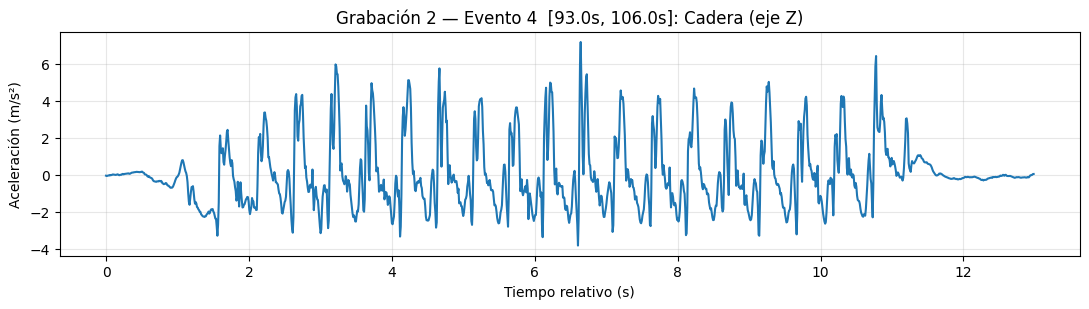

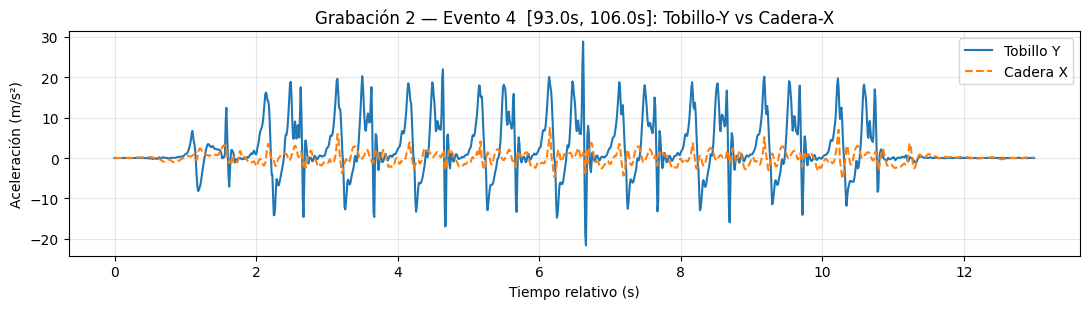

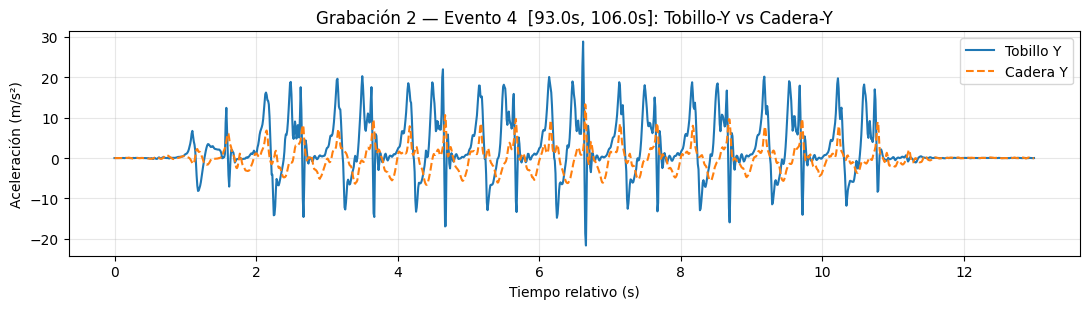

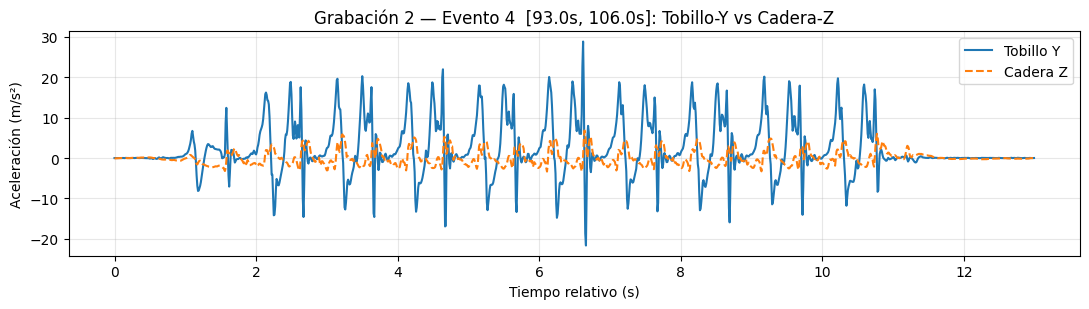

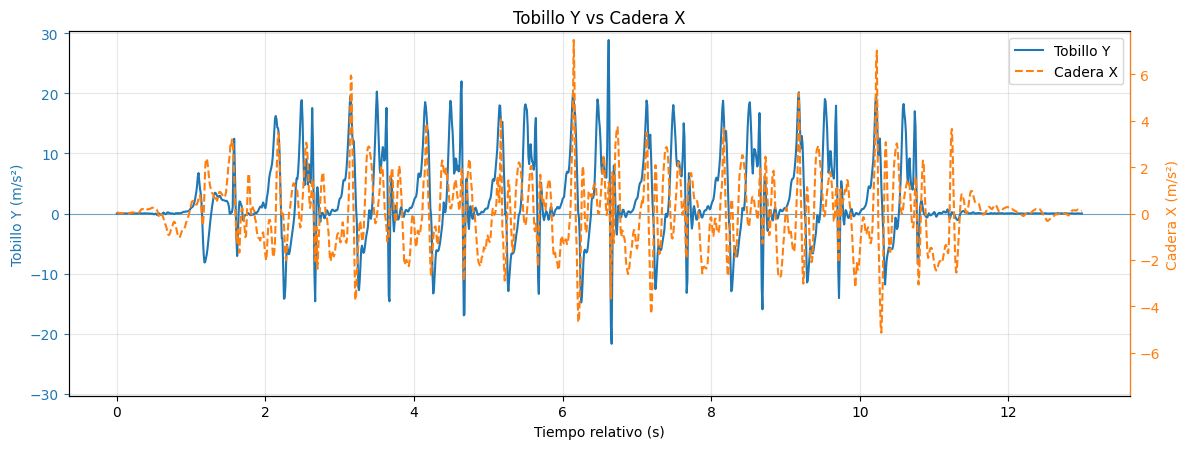

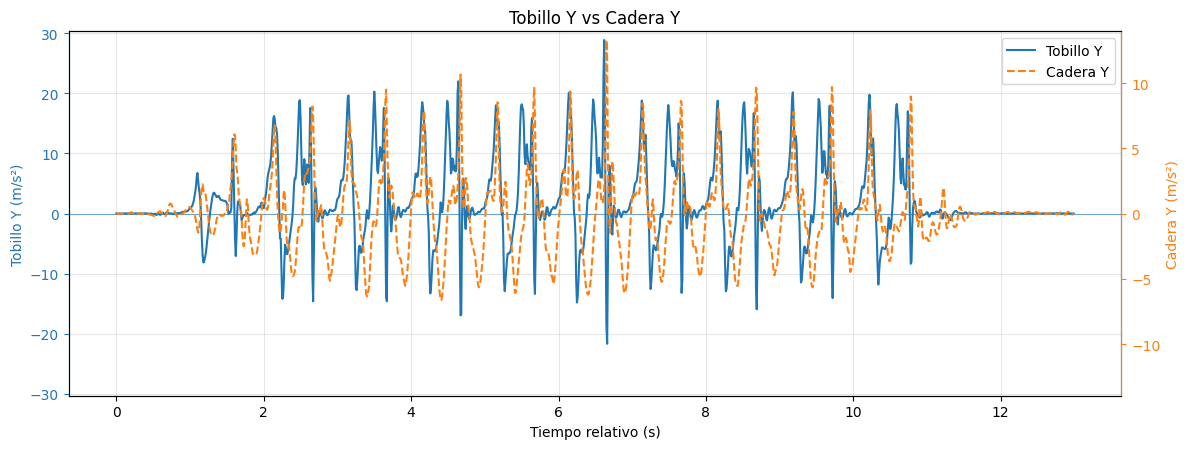

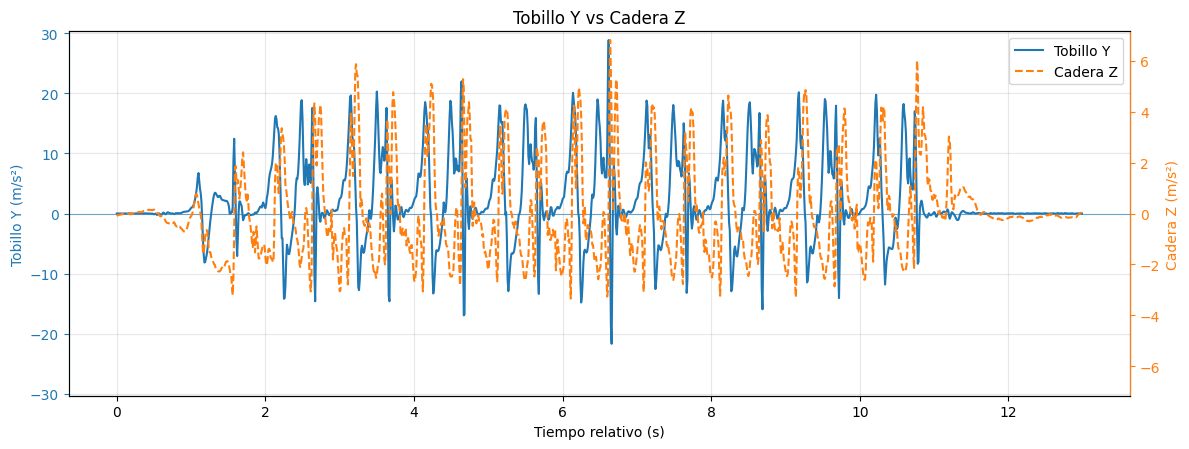

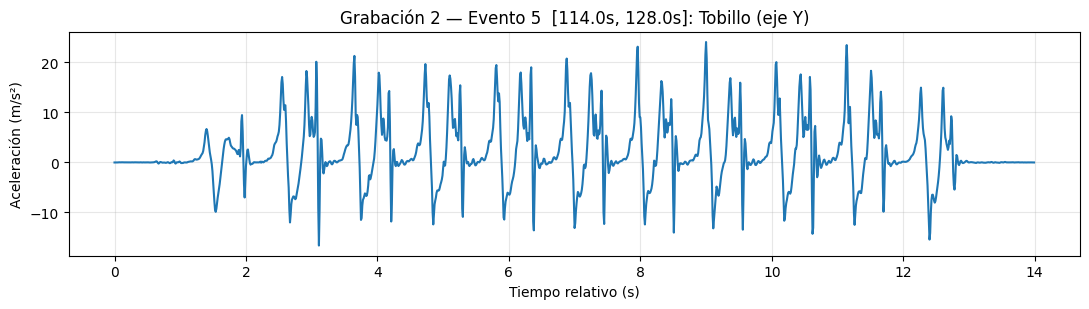

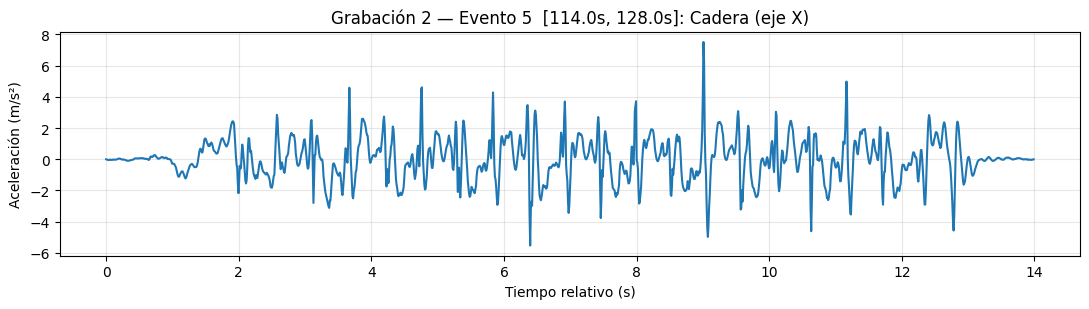

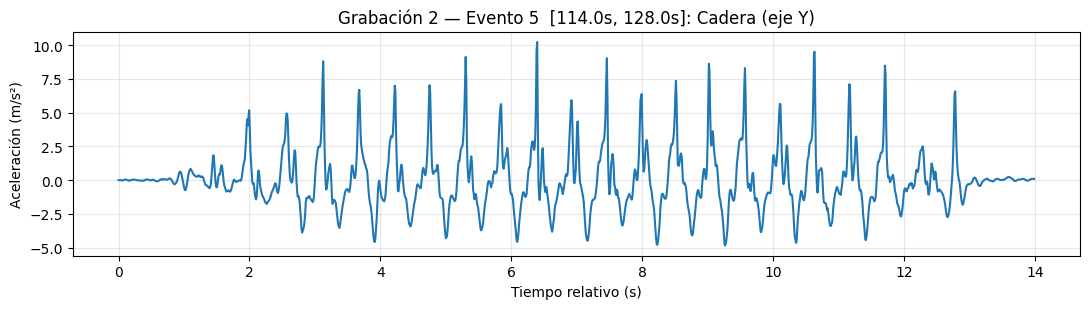

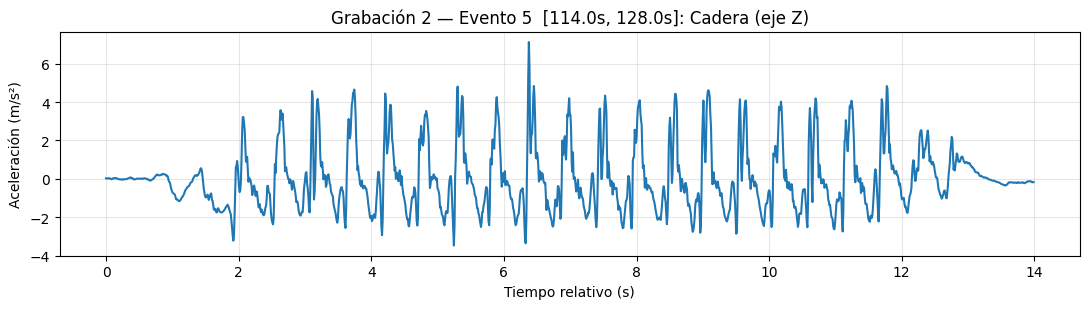

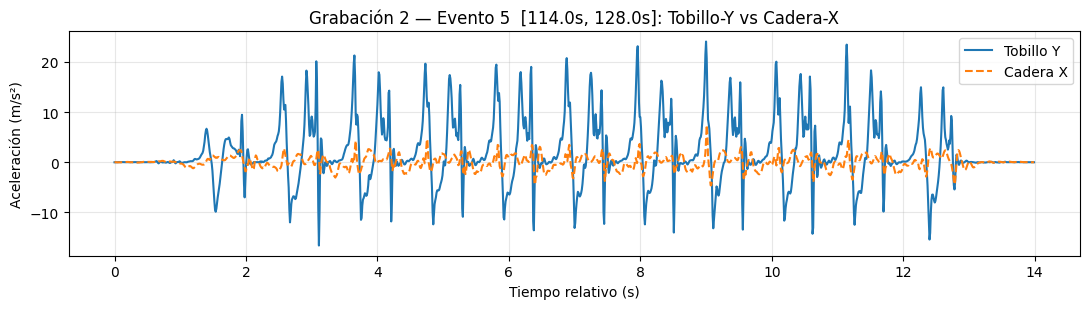

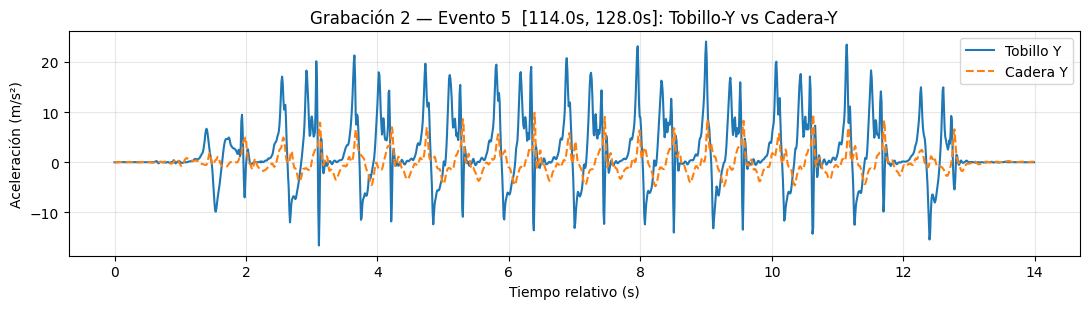

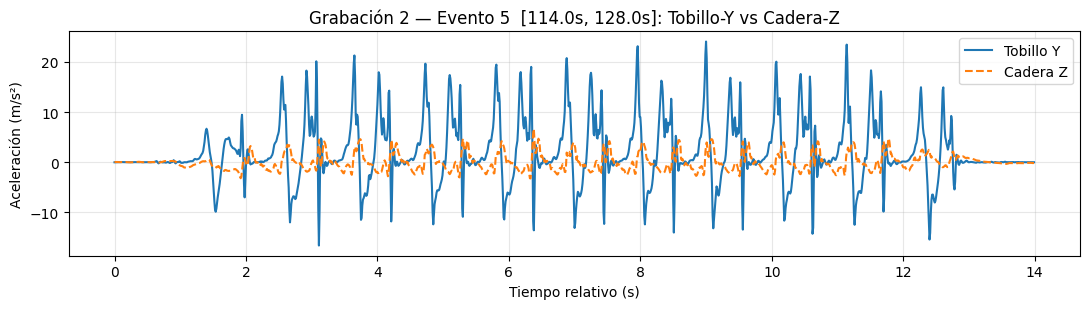

In [3]:
# %% Pintado por muestras (7 figuras por evento usando intervalos manuales) + 3 extras dual-axis para G2-E4
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.3
})

# ====== Intervalos [inicio_s, fin_s] (tus valores) ======
EVENTS_TOBILLO = {
    1: [(51.0, 69.0), (78.0, 94.0), (116.0, 137.0), (147.0, 171.0), (184.0, 201.0)],
    2: [(32.0, 45.0), (54.0, 66.0), (74.0, 85.0), (93.0, 106.0), (114.0, 128.0)]
}
# ========================================================

# --- Lectura con formato fijo: columns = seconds_elapsed, z, y, x ---
def load_fixed_format(csv_path: str):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    req = {"seconds_elapsed", "z", "y", "x"}
    if not req.issubset(df.columns):
        faltan = req - set(df.columns)
        raise ValueError(f"{csv_path}: faltan columnas {faltan}")
    t  = pd.to_numeric(df["seconds_elapsed"], errors="coerce").to_numpy()
    ax = pd.to_numeric(df["x"], errors="coerce").to_numpy()
    ay = pd.to_numeric(df["y"], errors="coerce").to_numpy()
    az = pd.to_numeric(df["z"], errors="coerce").to_numpy()
    m = np.isfinite(t) & np.isfinite(ax) & np.isfinite(ay) & np.isfinite(az)
    return t[m], ax[m], ay[m], az[m]

def find_file(base: str, idx: int):
    pattern = fr"(?i)Accelerometer{base}{idx}\.csv$"
    cand = [f for f in glob.glob("Accelerometer*.csv") if re.search(pattern, os.path.basename(f))]
    return sorted(cand)[0] if cand else None

def crop_interval(t, *signals, t0=None, t1=None, make_relative=True):
    m = (t >= t0) & (t <= t1)
    t_seg = t[m]
    if make_relative and t_seg.size:
        t_seg = t_seg - t_seg[0]
    sigs = [s[m] for s in signals]
    return (t_seg, *sigs)

def plot_segment_single(t, y, title, ylabel="Aceleración (m/s²)"):
    plt.figure(figsize=(11, 3.2))
    plt.plot(t, y, label=ylabel)
    plt.title(title)
    plt.xlabel("Tiempo relativo (s)")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_overlay(t_ref, y_ref, t2, y2, title, label2):
    if len(t_ref) == 0 or len(t2) == 0:
        return
    y2i = np.interp(t_ref, t2, y2)
    plt.figure(figsize=(11, 3.2))
    plt.plot(t_ref, y_ref, label="Tobillo Y")
    plt.plot(t_ref, y2i, "--", label=label2)
    plt.title(title)
    plt.xlabel("Tiempo relativo (s)")
    plt.ylabel("Aceleración (m/s²)")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# --- NUEVO: superposición con dos ejes verticales (0 alineado y colores diferenciados) ---
def plot_overlay_dual_axes(t_ref, y_ref, t2, y2, title, label_right, figsize=(12.0, 4.6)):
    """
    Dibuja Tobillo-Y (izq) y Cadera-{X|Y|Z} (dcha) con ejes separados.
    - 'figsize' queda expuesto para que lo ajustes (por defecto más horizontal).
    - Alinea y=0 a la MISMA altura en ambos ejes (límites simétricos respecto a 0).
    - Colores distintos y ejes coloreados a juego.
    """
    if len(t_ref) == 0 or len(t2) == 0:
        return

    # Interpolar cadera a la rejilla del tobillo
    y2i = np.interp(t_ref, t2, y2)

    # Colores (coinciden con la paleta por defecto de Matplotlib)
    c_left  = "#1f77b4"  # C0
    c_right = "#ff7f0e"  # C1

    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()

    # Curvas
    line_left,  = ax_left.plot(t_ref, y_ref,  color=c_left,  label="Tobillo Y")
    line_right, = ax_right.plot(t_ref, y2i,  "--", color=c_right, label=label_right)

    # Título y etiquetas
    ax_left.set_title(title)
    ax_left.set_xlabel("Tiempo relativo (s)")
    ax_left.set_ylabel("Tobillo Y (m/s²)", color=c_left)
    ax_right.set_ylabel(f"{label_right} (m/s²)", color=c_right)

    # Alinear y=0 a la misma altura -> límites simétricos respecto a 0
    def symmetric_limits(y, margin=0.05):
        max_abs = float(np.nanmax(np.abs(y))) if len(y) else 1.0
        if not np.isfinite(max_abs) or max_abs == 0:
            max_abs = 1.0
        lim = max_abs * (1 + margin)
        return (-lim, lim)

    ax_left.set_ylim(*symmetric_limits(y_ref))
    ax_right.set_ylim(*symmetric_limits(y2i))

    # Línea de referencia en y=0
    ax_left.axhline(0, lw=0.8, alpha=0.6)

    # Colorear ticks y ejes a juego
    ax_left.tick_params(axis='y', colors=c_left)
    ax_right.tick_params(axis='y', colors=c_right)
    ax_right.spines['right'].set_color(c_right)
    ax_left.spines['left'].set_color(c_left)

    # Leyenda combinada
    lines = [line_left, line_right]
    labels = [l.get_label() for l in lines]
    ax_left.legend(lines, labels, loc="upper right")

    # Grid solo en el eje izquierdo
    ax_left.grid(True, alpha=0.3)
    ax_right.grid(False)

    fig.tight_layout()
    plt.show()

def plot_sample(record_idx: int, bout_idx: int, tA, yA, tH, xH, yH, zH, t0, t1):
    # Recortes (tiempo relativo a cada intervalo)
    tA_s, yA_s = crop_interval(tA, yA, t0=t0, t1=t1)
    tH_x, xH_s = crop_interval(tH, xH, t0=t0, t1=t1)
    tH_y, yH_s = crop_interval(tH, yH, t0=t0, t1=t1)
    tH_z, zH_s = crop_interval(tH, zH, t0=t0, t1=t1)

    base = f"Grabación {record_idx} — Evento {bout_idx}  [{t0:.1f}s, {t1:.1f}s]"

    # 1) Tobillo Y
    plot_segment_single(tA_s, yA_s, title=f"{base}: Tobillo (eje Y)", ylabel="Aceleración (m/s²)")

    # 2–4) Cadera X, Y, Z (separadas)
    plot_segment_single(tH_x, xH_s, title=f"{base}: Cadera (eje X)")
    plot_segment_single(tH_y, yH_s, title=f"{base}: Cadera (eje Y)")
    plot_segment_single(tH_z, zH_s, title=f"{base}: Cadera (eje Z)")

    # 5–7) Superposiciones Tobillo-Y con cada eje de Cadera
    plot_overlay(tA_s, yA_s, tH_x, xH_s, title=f"{base}: Tobillo-Y vs Cadera-X", label2="Cadera X")
    plot_overlay(tA_s, yA_s, tH_y, yH_s, title=f"{base}: Tobillo-Y vs Cadera-Y", label2="Cadera Y")
    plot_overlay(tA_s, yA_s, tH_z, zH_s, title=f"{base}: Tobillo-Y vs Cadera-Z", label2="Cadera Z")

    # --- EXTRA SOLO PARA Grabación 2, Evento 4: tres gráficas con dos ejes y ---
    if record_idx == 2 and bout_idx == 4:
        # Ajusta aquí el tamaño si quieres otra relación de aspecto
        plot_overlay_dual_axes(tA_s, yA_s, tH_x, xH_s, title="Tobillo Y vs Cadera X",
                               label_right="Cadera X", figsize=(12.0, 4.6))
        plot_overlay_dual_axes(tA_s, yA_s, tH_y, yH_s, title="Tobillo Y vs Cadera Y",
                               label_right="Cadera Y", figsize=(12.0, 4.6))
        plot_overlay_dual_axes(tA_s, yA_s, tH_z, zH_s, title="Tobillo Y vs Cadera Z",
                               label_right="Cadera Z", figsize=(12.0, 4.6))

def main():
    for rec_idx in [1, 2]:
        f_tob = find_file("Tobillo", rec_idx)
        f_cad = find_file("Cadera", rec_idx)
        if not f_tob or not f_cad:
            print(f"[Aviso] Faltan archivos en grabación {rec_idx}: "
                  f"Tobillo({bool(f_tob)}), Cadera({bool(f_cad)})")
            continue

        # Cargar señales completas
        tA, xA, yA, zA = load_fixed_format(f_tob)
        tH, xH, yH, zH = load_fixed_format(f_cad)

        # Para cada intervalo de esa grabación: 7 figuras (y +3 extra para G2-E4)
        for k, (t0, t1) in enumerate(EVENTS_TOBILLO.get(rec_idx, []), start=1):
            plot_sample(rec_idx, k, tA, yA, tH, xH, yH, zH, t0, t1)

if __name__ == "__main__":
    main()
